In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print(pm.__version__)
print(az.__version__)

5.7.2
0.16.1


In [2]:
data_01 = pd.read_csv('data_01.csv')
data_02 = pd.read_csv('data_02.csv')
data_03 = pd.read_csv('data_03.csv')
data_04 = pd.read_csv('data_04.csv')
data_05 = pd.read_csv('data_05.csv')
data_06 = pd.read_csv('data_06.csv')

In [3]:
datasets = [data_01, data_02, data_03, data_04, data_05, data_06]

In [4]:
idd = []
for i, d in enumerate(datasets):
    datasets[i]['x'] = (d['x'] - d['x'].mean()) / d['x'].std()
    datasets[i]['y'] = (d['y'] - d['y'].mean()) / d['y'].std()
    idd.extend([i] * len(d))

x_m = np.concatenate([d['x'] for d in datasets])
y_m = np.concatenate([d['y'] for d in datasets])
M = len(datasets)

In [5]:
with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=20)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=20)
    β_μ = pm.Normal('β_μ', mu=0, sigma=5)
    β_σ = pm.HalfNormal('β_σ', sigma=5)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idd] + β[idd] * x_m,
    sigma=ε, nu=ν, observed=y_m)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace = pm.sample(3000, tune=1000, target_accept=.8)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


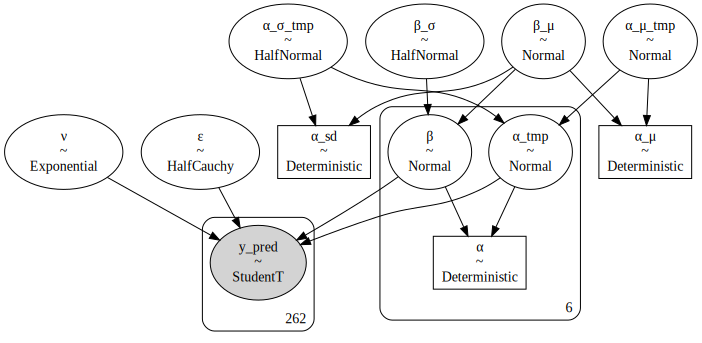

In [6]:
pm.model_to_graphviz(hierarchical_model)

In [7]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,-0.001,0.031,-0.056,0.056,0.001,0.001,1544.0,2338.0,1.00
β_μ,0.650,0.445,-0.107,1.508,0.037,0.026,400.0,119.0,1.01
α_tmp[0],0.001,0.033,-0.066,0.060,0.001,0.001,1781.0,2065.0,1.00
α_tmp[1],-0.004,0.034,-0.069,0.058,0.001,0.000,2227.0,2992.0,1.00
α_tmp[2],0.001,0.032,-0.060,0.063,0.001,0.000,2147.0,3195.0,1.00
α_tmp[3],-0.002,0.033,-0.066,0.060,0.001,0.000,2216.0,2858.0,1.00
α_tmp[4],-0.000,0.034,-0.067,0.065,0.001,0.001,1916.0,4087.0,1.00
α_tmp[5],-0.002,0.054,-0.105,0.091,0.001,0.001,2501.0,2901.0,1.00
β[0],0.916,0.048,0.825,1.002,0.001,0.001,1172.0,2819.0,1.00
β[1],0.891,0.054,0.793,0.993,0.002,0.002,609.0,1152.0,1.00


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (26), generating only 20 plots
  warnings.warn(


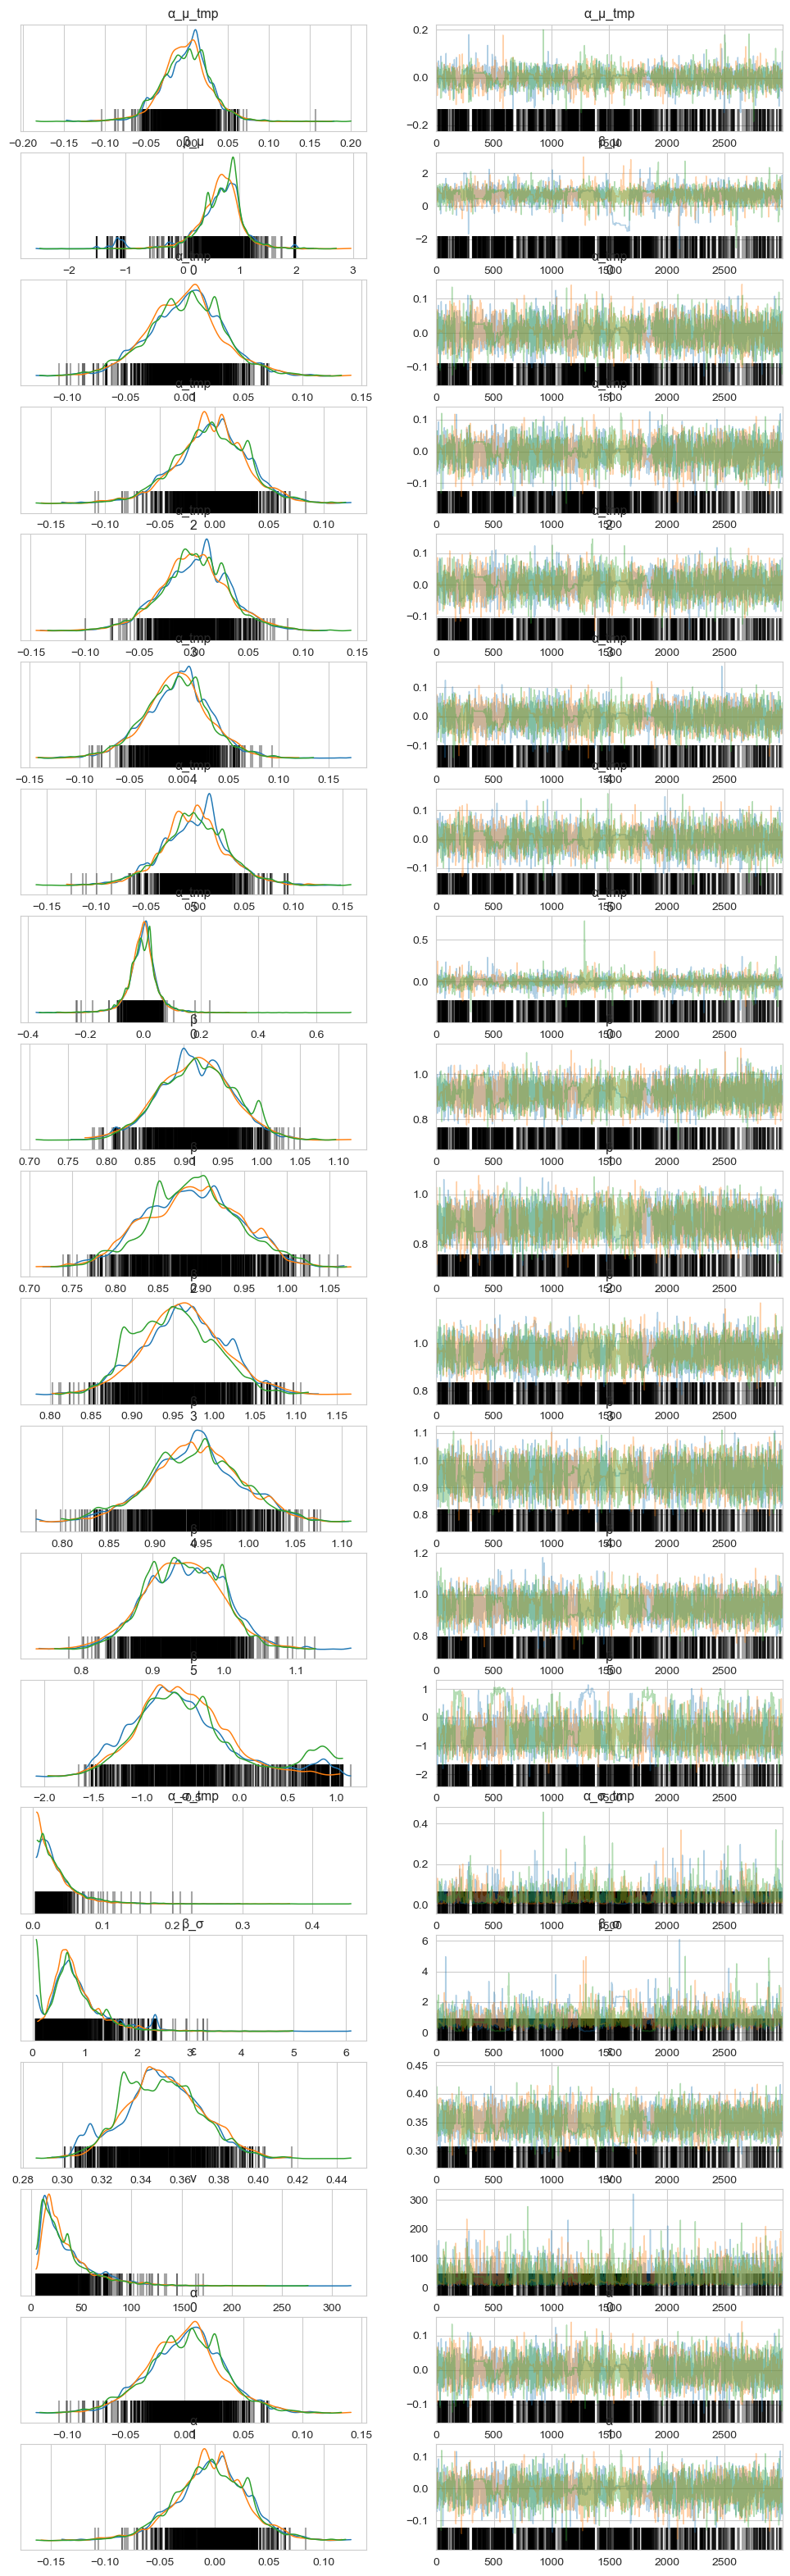

In [9]:
az.plot_trace(trace, compact=False);

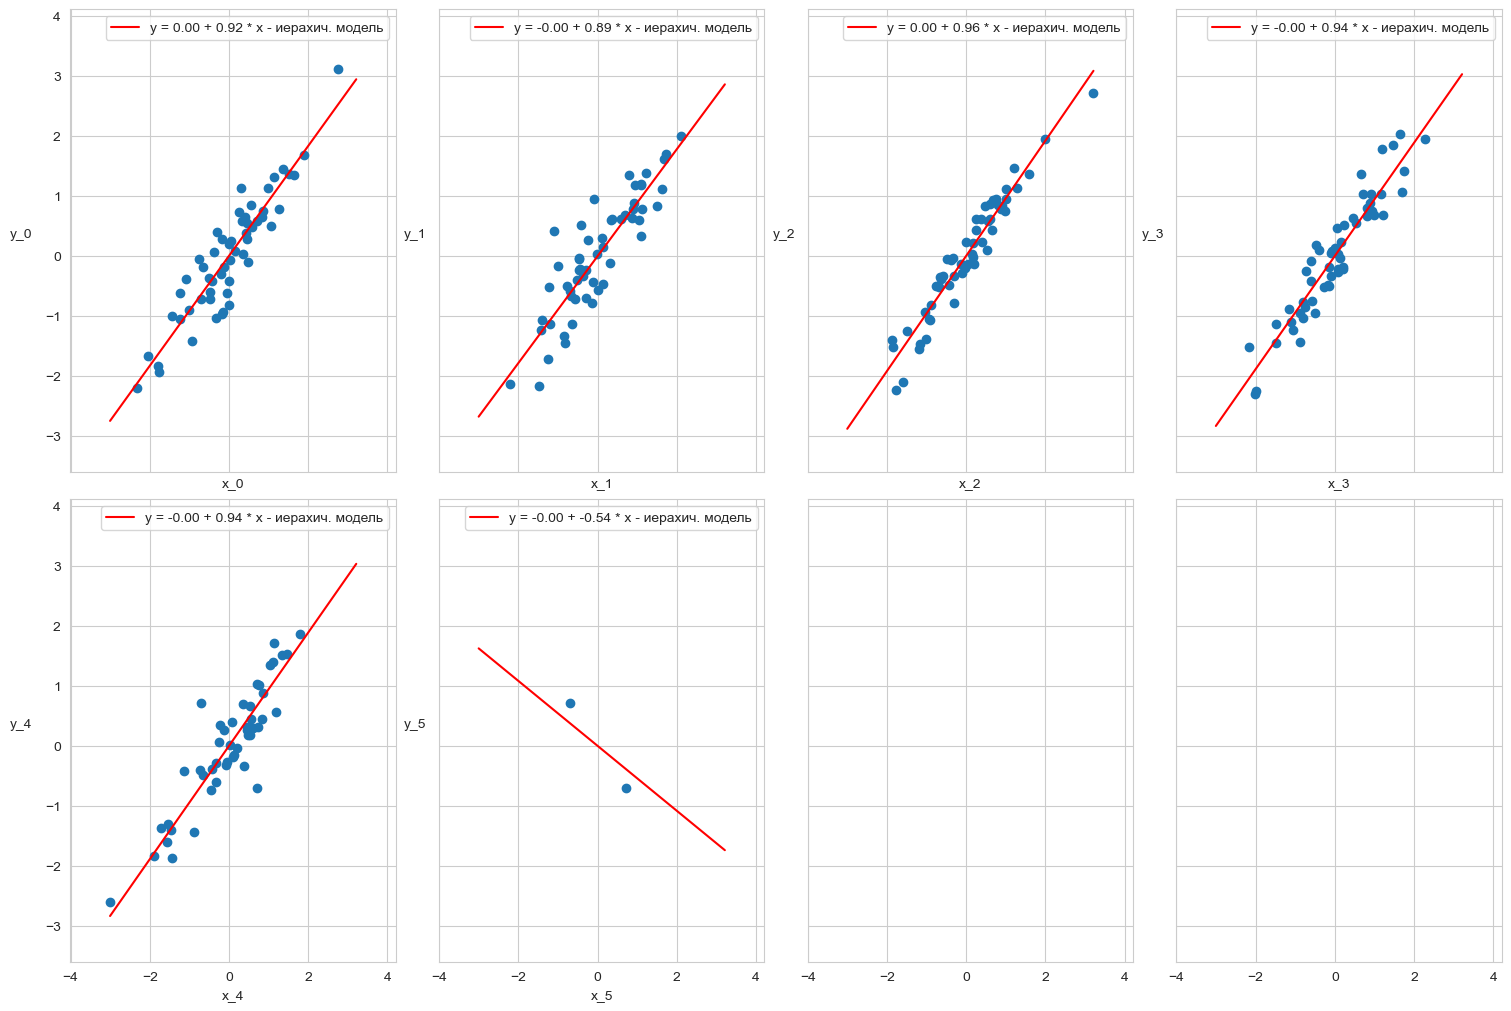

In [10]:
_, ax = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hm = trace.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, 55
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    N = len(datasets[i])
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    
    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N